# Machine Learning Pipeline - Scoring New Data (Henry's Comments)

**This notebook reveals the problem that we would have if we don't use sklearn pipeline and/or open libraries**

Let's imagine that a colleague from the business department comes and asks us to score the data from last months customers. They want to be sure that our model can predict the SalePrice of the most recent data that the organization has (the latest data does NOT have SalePrice-- that's where our model comes in). 

We need to take our data Pipeline (notebooks 1-4), and use it to transform the new/more recent raw data to "processed" data (with missing values imputed, and the engineered features derived, etc...). Next, we used our trained model (saved from notebook 4) to make predictions on SalePrice from the processed data. **This is what it means to "score the recent data"**.

Below we present one potential solution.

What could we have done better?

In [32]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for the yeo-johnson transformation
import scipy.stats as stats

# to save the model
import joblib

## Import data
- In notebooks 1-4, we loaded the "train.csv", and then split it into train and test
- We never used the 'holdout/validation' dataset "test.csv"
- In this notebook, we will ONLY use "test.csv". This will be the unknown/more recent observations given to you by your coworker.
- 'test.csv" only has the features, but it doesn't have the response variable 'SalePrice'

In [33]:
# load the unseen / new dataset
data = pd.read_csv('../data/test.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Data processing: we repeat all the steps in our data pipeline from notebook 2-4

In [34]:
# drop the id variable

data.drop('Id', axis=1, inplace=True)

data.shape

(1459, 79)

## Missing values

### Imputing missing values: Categorical variables

- Replace missing values with the string "missing" in those variables with a lot of missing data (>10%). 
- Replace missing data with the most frequent category (mode) in variables that contain fewer observations with missing values (<10%). 

In [35]:
# first we needed to cast MSSubClass as object

data['MSSubClass'] = data['MSSubClass'].astype('O')

In [36]:
# We replicate our data pipeline-- recall that some variables have lots of missing variable
# and therefore we need to impute all missing values in those variables with the level "Missing".
# We assume that in both datasets (the dataset used in notebooks 1-4 and the new dataset used in this notebook), 
# the same 5 variables have >10% missing. BUT WHAT IF THIS CHANGES IN THE NEW DATASET?

# In notebook 2: 
# with_string_missing = [var for var in cat_vars_with_na if X_train[var].isnull().mean()>=0.1]

# We "hardcode" with_string_missing in this notebook
with_string_missing = ['Alley', 'FireplaceQu',
                       'PoolQC', 'Fence', 'MiscFeature']

In [37]:
# The following variables are those with less missingness (<10%) 
# In notebook 2:
# with_frequent_category = [var for var in cat_vars_with_na if X_train[var].isnull().mean()<0.1]

# For categorical variables with less than 10% missing, I need to find the mode of the 
# variable (the most frequent level). We use the .mode() function.
# Then, in notebook 2, I created a dictionary with categorical variable as key, and their mode as value

# Here, I copy this dictionary directly and apply it to my new/unknown dataset

# hardcode this
with_frequent_category = {
    'MasVnrType': 'None',
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1': 'Unf',
    'BsmtFinType2': 'Unf',
    'Electrical': 'SBrkr',
    'GarageType': 'Attchd',
    'GarageFinish': 'Unf',
    'GarageQual': 'TA',
    'GarageCond': 'TA',
}

### Area of improvement
 
- We copy this dictionary from the Feature-engineering notebook
- Note that we needed to hard-code this dictionary by hand, with the key as the variable and the value as the variable's mode
- In my feature engineering notebook (notebook 2), if I change something (say use 80-20 train test split instead), I might get different variables in "with_string_missing" and "with_frequent_cateogory". That means I need to re-hardcode the variables in these lists every time I make a change in my feature engineering notebook.

#### Question: What the mode in the above dictionary changes in the new/more recent dataset? In this case, we can't simply copy the dictionary from notebook # 2 (computed from the old dataset) and use it for my new/more recent dataset!

In [38]:
# For categorical variables with high missingness, we replace missing values with new label: "Missing"
data[with_string_missing] = data[with_string_missing].fillna('Missing')

# For categorical variables with low missingness, we replace missing values with the most frequent category (mode)
for var in with_frequent_category.keys():
    data[var].fillna(with_frequent_category[var], inplace=True)

### Imputing missing values: Numerical variables

As before in notebook 2, to engineer missing values in numerical variables, we will:

- Add a binary missing value indicator variable
- And then replace the missing values in the original variable with the mean

In [39]:
# In notebook 2: 
# Create a list of continuous variables that contain missing values
# vars_with_na = [var for var in num_vars if X_train[var].isnull().sum()>0]
# We identified three continuous variables with missing values: 'LotFrontage','MasVnrArea','GarageYrBlt'.
# For each of these variables, we compute its mean value, and then impute the missing value with the mean value

# Here, we hardcoded the dictionary (key = variable, value = mean value), and use it to impute the missing values 
# for the three variables 'LotFrontage', 'MasVnrArea', 'GarageYrBlt' in the new/more recent dataset.
vars_with_na = {
    'LotFrontage': 69.87974098057354,
    'MasVnrArea': 103.7974006116208,
    'GarageYrBlt': 1978.2959677419356,
}

### Area of improvement
- We hardcoded this dictionary from the output of the Feature engineering notebook (notebook 2).
- Alternatively, I can save the above dictionary as a pickle, and then load the dictionary in this notebook. That means I will need to add new code in the feature engineering notebook (notebook 2) to save dictionary as pickle. Either way, we need to do manual/extra work.
- What if the mean changes in the new/more recent dataset? In addition to these three variables, what if we have other continuous variables with missing value in the more recent dataset?

In [40]:
# Impute missing values with the dictionary above

for var in vars_with_na.keys():

    # add binary missing indicator (in train and test)
    data[var + '_na'] = np.where(data[var].isnull(), 1, 0)

    # replace missing values by the mean (from the hardcoded dictionary above)
    data[var].fillna(vars_with_na[var], inplace=True)

In [41]:
# Check to see if there are any more missing values in the three continuous variables
data[vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [42]:
# Check the binary missing indicator variables
data[['LotFrontage_na','MasVnrArea_na','GarageYrBlt_na']].sample(5)

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
534,0,0,0
822,0,0,0
1086,0,0,0
1030,1,0,0
90,0,0,0


## Feature engineering for continuous variables
### Temporal variables (Year variables)
- As before, we will replace the Year variables with "elapsed time" variables
- For example, replace YearBuilt with the elapsed time between YearBuilt and YrSold.

## Area of Improvement: we probably want to have a separate script that contains all helper functions.

In [43]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [44]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)

In [45]:
# now we drop YrSold
data.drop(['YrSold'], axis=1, inplace=True)

## Transformation for continuous variables

### Logarithmic transformation

We will transform with the logarithm the positive numerical variables in order to get a more Gaussian-like distribution.

In [46]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    data[var] = np.log(data[var])

### Yeo-Johnson transformation

We will apply the Yeo-Johnson transformation to LotArea.

In [47]:
# Note how we use the lambda that we learned from the train set
# in notebook 2 and apply Yeo-Johnson transformation on
# 'LotArea' in the unknown/recent data

data['LotArea'] = stats.yeojohnson(data['LotArea'], lmbda=-12.55283001172003)

### Area of improvement
 
- We use lambda that was estimated from the train dataset from 'train.csv', and then directly use it to perform Yeo-Johnson transformation on LotArea in the more recent data. Is this valid?

## Binarize skewed variables

There were a few continuous variables that are very skewed, we would transform those into binary variables.

In [48]:
# hardcode this lust of very skewed variables
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

# Binarize the skewed variables
for var in skewed:    
    # map the variable values into 0 and 1
    data[var] = np.where(data[var]==0, 0, 1)

### Area of improvement
- **The 'very skewed' variables were identifed NOT from the unknown/recent dataset, but from the old train dataset from 'train.csv'. What if a different set of variables is very skewed in the unknown/recent dataset?**

## Categorical variables: recoding
- As with notebook 2, we will recode all house quality related variables
- Copy the dictionary from notebook 2 for the mapping
- These are variables which values have an assigned order, related to quality. For more information, check Kaggle website.

## Area of Improvement: Have these mappings stored in a config file. Then we can read mappings from the config file in one or more notebooks

In [49]:
# re-map strings to numbers, which determine quality

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    data[var] = data[var].map(qual_mappings)

In [50]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

data[var] = data[var].map(exposure_mappings)

In [51]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    data[var] = data[var].map(finish_mappings)

In [52]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

data[var] = data[var].map(garage_mappings)

In [53]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

data[var] = data[var].map(fence_mappings)

## Do a final check of missing values in variables in the new dataset
- So far, we impute missing values for two groups of categorical variables:
    - Categorical variables with >10% missing (with_string_missing). We impute the missing values with a new level "Missing".
    - Categorical variables with <10% missing. We impute the missing values for these variables with the mode (most frequent level) 
    
    
We never really look at the extent of missingness in the categorical variables in the new dataset 'test.csv'. Instead, we assume the missingness is the same across old and new datasets.

Based on the old dataset, we grouped categorical variables as follows, and then impute with different methods: <br><br> 

with_string_missing = ['Alley', 'FireplaceQu',
                       'PoolQC', 'Fence', 'MiscFeature']
                       
                       
<br>                      
with_frequent_category = {
    'MasVnrType': 'None',
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1': 'Unf',
    'BsmtFinType2': 'Unf',
    'Electrical': 'SBrkr',
    'GarageType': 'Attchd',
    'GarageFinish': 'Unf',
    'GarageQual': 'TA',
    'GarageCond': 'TA',
}

- Similarly, for continuous variables, we assume the variables that have missing values are the same across the old and new dataset. We performed mean imputation on 3 continuous variables (that has missing values in the old dataset, we assume they are the only continuous variables that have missing values in the new dataset)


**Let's do a final check to make sure all variables (after we performed imputation) in the new dataset has no missing values.**

In [54]:
# Check for missing values in data frame
[var for var in data.columns if data[var].isnull().sum() > 0]

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea',
 'SaleType']

## Surprise!
- Even after we perform imputation on the new dataset, there remain a few variables with missing data!!
- Reason: there are variables that have missing values ONLY in the new data 'test.csv', but not in the old data!

In [55]:
# Did the above variables have missing data in the train set? 
# Note that variables with missing values in 
# "with_frequent_category", 'with_string_missing', and continuous variables in 'vars_with_na' are 
# "copy and pasted" from notebook 2. It doesn't necessarily reflect the variables with missingness in the new dataset!

# Remaining variables with missing values in the new data
with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

# Check to see if these remaining variables are in any of the list of variables with missing values 
# that are copy and pasted from notebook 2 (based on the old data)
[var for var in with_null if var in list(
    with_frequent_category.keys())+with_string_missing+list(vars_with_na.keys())]

[]

**IMPORTANT**

In the new data, we have a bunch of variables that contain missing values. These variables do not have missing values in the old data.

## Removing Rare Labels

For the remaining categorical variables (cat_other identified in notebook 2), we will group categories that are present in less than 1% of the observations into a "Rare" string.

- We basically use the "frequent levels" of cat_others that we identified from the old data ('train.csv')
- We do a lot of hard-coding here and have to write a dictionary manually from the outputs of notebook 2.
- Can you think of an alternative? Perhaps we could have save this as a numpy pickle and load it here, instead of hard-coding.
- But that means that we need to go back to the Feature Engineering notebook, and change the code so that we store the pickle (so some changes are still needed)

## Area of Improvement: Store these mappings in a pickle (add code to save dictionary as pickle in notebook 2), and then load them in this notebook

In [56]:
# A dictionary of NON-rare level for each "other" categorical variable
frequent_ls = {
    'MSZoning': ['FV', 'RH', 'RL', 'RM'],
    'Street': ['Pave'],
    'Alley': ['Grvl', 'Missing', 'Pave'],
    'LotShape': ['IR1', 'IR2', 'Reg'],
    'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
    'Utilities': ['AllPub'],
    'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
    'LandSlope': ['Gtl', 'Mod'],
    'Neighborhood': ['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
                     'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
                     'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
                     'Somerst', 'StoneBr', 'Timber'],

    'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
    'Condition2': ['Norm'],
    'BldgType': ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
    'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Gable', 'Hip'],
    'RoofMatl': ['CompShg'],
    'Exterior1st': ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],

    'Exterior2nd': ['AsbShng', 'BrkFace', 'CmentBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'],

    'MasVnrType': ['BrkFace', 'None', 'Stone'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab'],
    'Heating': ['GasA', 'GasW'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['FuseA', 'FuseF', 'SBrkr'],
    'Functional': ['Min1', 'Min2', 'Mod', 'Typ'],
    'GarageType': ['Attchd', 'Basment', 'BuiltIn', 'Detchd'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['Missing'],
    'MiscFeature': ['Missing', 'Shed'],
    'SaleType': ['COD', 'New', 'WD'],
    'SaleCondition': ['Abnorml', 'Family', 'Normal', 'Partial'],
    'MSSubClass': ['20', '30', '50', '60', '70', '75', '80', '85', '90', '120', '160', '190'],
}

In [57]:
for var in frequent_ls.keys():
    # replace rare categories (categories NOT in the values in the above dictionary) by the string "Rare"
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')

## Encoding the "other" categorical variables with numbers
- Enumerate the levels of variables in cat_others
- Assign smaller numeric values to levels that on average have smaller SalePrice
- By doing this, we can treat the "other" categorical variables as "ordinal variables", which have a monotonic relationship with SalePrice
- We use the ordinal mappings computed from the old data 'train.csv' in notebook 2. Lots of hardcoding is needed.

In [58]:

ordinal_mappings = {
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Street': {'Rare': 0, 'Pave': 1},
    'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,
                     'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7,
                     'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                     'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,
                     'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19,
                     'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},
    
    'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CemntBd': 9, 'VinylSd': 10},
    
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},
    
    'MasVnrType': {'Rare': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'Missing': 0, 'Rare': 1},
    'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5, '85': 6,
                   '70': 7, '80': 8, '20': 9, '75': 10, '120': 11, '60': 12},
}

In [59]:
for var in ordinal_mappings.keys():

    ordinal_label = ordinal_mappings[var]

    # use the dictionary to replace the categorical strings by integers
    data[var] = data[var].map(ordinal_label)

# --End of data processing and feature engineering--

### Check absence of na in the processed data set

In [60]:
# check absence of na in the data set

with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

len(with_null)

13

## Even after we finished data processing and feature engineering, there remains 13 variables with missing values. This is due to difference between the old and new datasets. This is a common problem in deployment

In [61]:
# in the real world, we would try to understand where they are coming from
# and why they were NOT present in the training set

# here I will just fill them in quickly to proceed with the demo

data.fillna(0, inplace=True)

## Feature Scaling

We will scale features to the minimum and maximum values:

In [62]:
# load the scaler we saved in the notebook on Feature Engineering and apply it to the new dataset

scaler = joblib.load('../models/minmax_scaler.joblib') # use joblib.load() to load the saved scalar

data = pd.DataFrame(
    scaler.transform(data),
    columns=data.columns
)

In [63]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.083333,0.0,0.495064,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.75,0.0,0.0,0.454545,0.333333,0.0,0.0,0.0,0.0
1,0.083333,0.0,0.499662,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,1.0,0.454545,0.333333,0.0,0.0,0.0,0.0
2,0.083333,0.0,0.466207,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.75,0.0,0.0,0.181818,0.333333,0.0,0.0,0.0,0.0
3,0.083333,0.0,0.485693,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,0.0,0.454545,0.333333,0.0,0.0,0.0,0.0
4,0.083333,0.0,0.265271,0.0,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0


## Feature selection
- We will load the selected features (computed from the old dataset), and then only filter the selected features in the new dataset

In [64]:
features = pd.read_csv('../outputs/selected_features.csv')
features = features['0'].to_list() 

# reduce the train and test set to the selected features
data = data[features]

data.shape

(1459, 36)

We engineered many variables, but after going through the feature selection step, we only used 36 variables to train our model.

**What could we do differently?**

We could have, of course, engineered only the variables that we are going to use in the model. But that means:

- identifying which variables we need (which might be different depending on the variables that we derived in the first place. So we still need to do feature engineering first before feature selection.
- identifying which transformation we need for each variable
- redefining our dictionaries accordingly
- retraining the MinMaxScaler only on the selected variables (at the moment, it is trained on the entire dataset)
- we need to create extra code to train the scaler only on the selected variables. Probably removing the scaler from the Feature Engineering notebook and passing it onto the Feature Selection one.

We need to be really careful in re-writing the code here to make sure we do not forget or engineer wrongly any of the variables.

## Notes on training the minmax scalar:
- The scalar was trained on the entire dataset (and then persisted with joblib).
- Even if we only use a subset of variables to train our model, we cannot ONLY apply the scalar on that subset of variables since the scalar was trained on the entire dataset.
- Two alternatives:
    - (What is being done now): train scalar on entire dataset, apply data on entire dataset, and then filter variables that we will use to train the model.
    - Do feature selection first, then train scalar on the data subset, and apply scalar on data subset.

## Making predictions
- Armed with the processed "new" data, we load the Lasso model (from notebook 4) and make predictions on SalePrice
- **This is what we mean by "scoring" the new data**

In [65]:
# Load the trained model from old data
reg = joblib.load('../models/linear_regression.joblib')

In [66]:
# Make predictions from the processed 'new' data
# Note that the new data "test.csv" has no SalePrice
pred = reg.predict(data)

<AxesSubplot:>

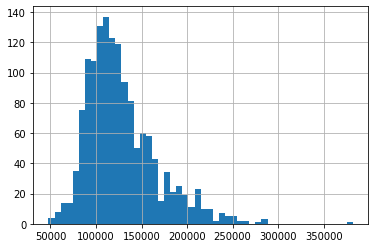

In [67]:
# let's plot the predicted sale prices
pd.Series(np.exp(pred)).hist(bins=50)

## What shortcomings, inconvenience and problems did you find when scoring new data?

### List of problems

- re-wrote a lot of code ==> repetitive
- hard coded a lot of parameters ==> if these change we need to re-write them again
- engineered a lot of variables that we actually do not need for the model
- There are additional variables in the new data with missing data.

We can minimize these hurdles by using Open-source libraries in the next notebook. 